# Combining edges and masks

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

In [2]:
import sys
sys.path.append("..")

%autoreload 2
from pipeline import LaneColorMasking, EdgeDetection, EdgeDetectionSWT
from scripts.processing import undistort_and_warp, build_roi_mask
from scripts.channels import show_single_image, show_two_images
from scripts.conversion import bgr2lab
roi_mask = build_roi_mask()

In [3]:
friendly_paths = glob.glob(os.path.join('..', 'test_images', 'test*.jpg'))
hard_paths = glob.glob(os.path.join('..', 'test_images', 'challenge*.jpg'))
len(friendly_paths), len(hard_paths)

(6, 9)

In [4]:
def get_test_image(i: int, resize: bool=True) -> np.ndarray:
    img = cv2.imread(hard_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (0, 0), fx=0.25, fy=0.25) if resize else img

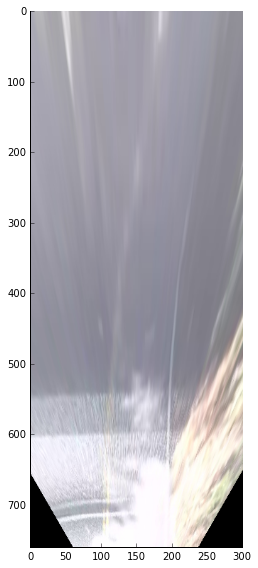

In [5]:
test_img = get_test_image(0, resize=False)
warped = undistort_and_warp(test_img)
show_single_image(warped, size=(4, 8))

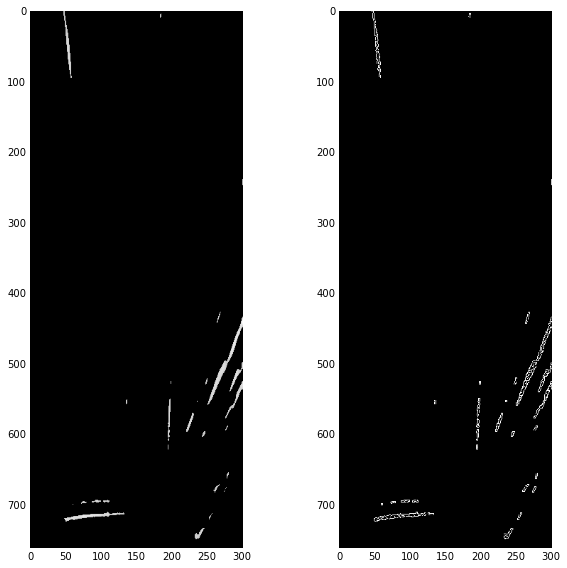

In [6]:
edg = EdgeDetection(detect_lines=False, mask=roi_mask)
filtered = edg.filter(warped, is_lab=False)
edges = edg.detect(warped, is_lab=False)
show_two_images(filtered, edges)

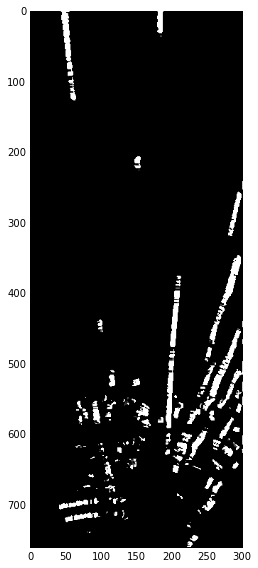

In [7]:
swt = EdgeDetectionSWT(mask=roi_mask)
swt_filtered = swt.filter(warped, is_lab=False)
show_single_image(swt_filtered)

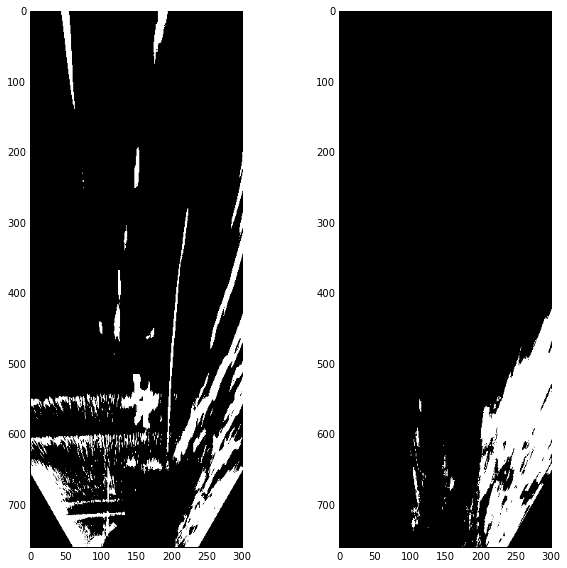

In [8]:
lcm = LaneColorMasking(blue_threshold=20)
lcm.detect_lines = False
lcm.blue_threshold = 25
lcm.light_cutoff = .9
mask_l, mask_b = lcm.process(warped, is_lab=False)
show_two_images(mask_l, mask_b)

## Combination of candidates

As can be seen from the above results, each candidate comes with its own errors. A simple way to tackle this is to use a quorum of answers, or using a boosting strategy to combine a weighted sum of the results.

The easiest approach is to just use a two-out-of-three scheme, where a lane marking candidate is considered valid if at least two out of three guesses agree.

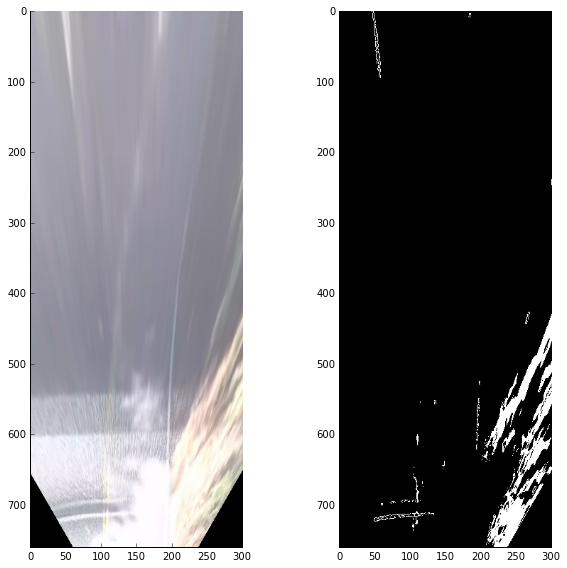

In [9]:
mask_le = mask_l & edges
mask_be = mask_b & edges
mask_lb = mask_l & mask_b
mask = mask_lb | mask_le | mask_be
show_two_images(warped, mask)

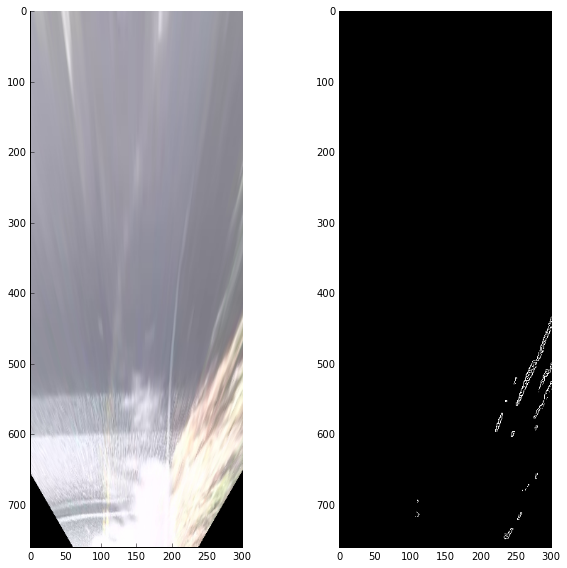

In [10]:
mask_lbe = mask_l & mask_b & edges
show_two_images(warped, mask_lbe)

We find that this scheme is not very helpful in the current configuration. We can try increasing the edge guesses by suppressing fewer candidates:

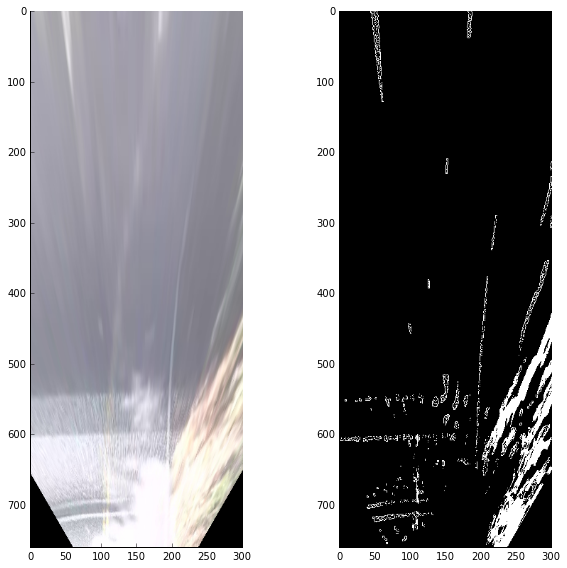

In [11]:
edg.filter_threshold = .03
edges = edg.detect(warped, is_lab=False)
mask_le = mask_l & edges
mask_be = mask_b & edges
mask_lb = mask_l & mask_b
mask = mask_lb | mask_le | mask_be
show_two_images(warped, mask)

## Additive combination

Since the next step will utilise pixel values for regressing the lane, we can make use of all
information rather than just a common subset of it. By simply adding the masks, locations where all 
three masks agree will have a high value, whereas results from only a single mask will be counted
by a lower amount.

By squaring the resulting mask we can ensure that more combinations are considered exponentially stronger.

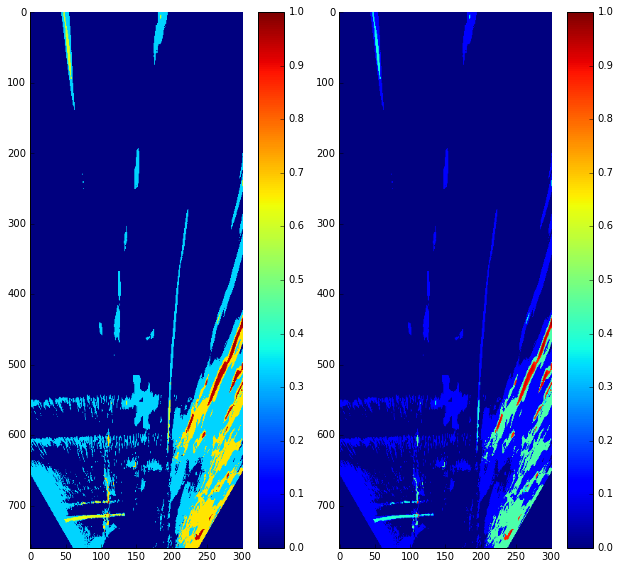

In [12]:
mask_sum = np.float32(filtered) / filtered.max()
mask_sum += np.float32(mask_l) / 255.
mask_sum += np.float32(mask_b) / 255.
mask_sum /= 3.
mask_sum_sq = mask_sum ** 2
show_two_images(mask_sum, mask_sum_sq, vmin=0, vmax=1, cmap='jet', colorbar=True)

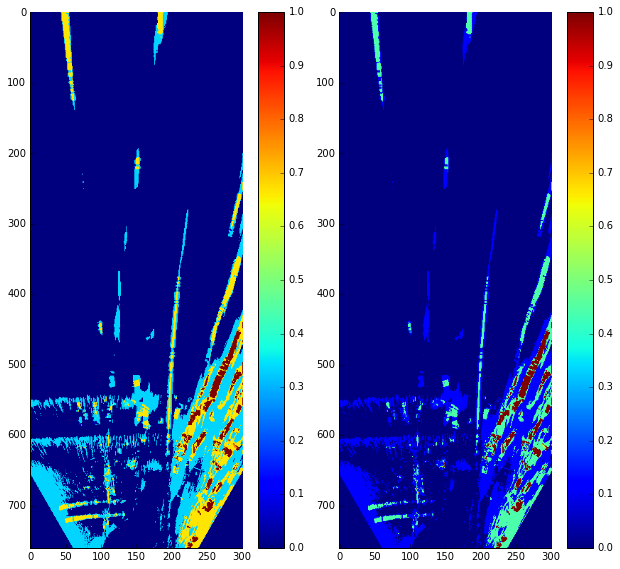

In [13]:
mask_sum = np.float32(swt_filtered) / swt_filtered.max()
mask_sum += np.float32(mask_l) / 255.
mask_sum += np.float32(mask_b) / 255.
mask_sum /= 3.
mask_sum_sq = mask_sum ** 2
show_two_images(mask_sum, mask_sum_sq, vmin=0, vmax=1, cmap='jet', colorbar=True)